# Regression of the Higgs transverse momentum (visible or not) in ttH multilepton 

# Authored by Pietro Vischia pietro.vischia@cern.ch

2020-09-29: warning: I think last time I used this notebook I have modified the code without recreating the plots. Or the contrary. So basically the current code likely results in different plots than those stored here.

In [25]:
# First import stuff
import pandas as pd
import math
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
import pylab
import sklearn as sk
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras as kr
from keras.models import Sequential
from keras.layers import InputLayer, Input
from keras.layers import Reshape, MaxPooling2D
from keras.layers import Conv2D, Dense, Flatten, Dropout
from keras import optimizers
from keras.layers import Dense, Activation
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import PReLU
from tensorflow.keras.layers import BatchNormalization
import seaborn as sns
from livelossplot import PlotLossesKeras


print('Using matplotlib version', matplotlib.__version__)
print('Using sklearn version', sk.__version__)
print('Using tensorflow version', tf.__version__)
print('Using keras version', kr.__version__)

import socket
my_hostname=socket.gethostbyaddr(socket.gethostname())[0]
print('You are running on ', my_hostname)

Using matplotlib version 3.2.2
Using sklearn version 0.23.1
Using tensorflow version 2.3.1
Using keras version 2.4.3
You are running on  derek-ThinkPad-13


In [26]:
import os

#idir = 'inputs/2016' # old shit
#idir = 'inputs/2016_skimmed'
#idir = 'inputs/2016_skimmed_masses'
#idir = 'inputs/2016_skimmed_drll'
idir = '/nfs/user/pvischia/tth/dnn/inputs/2016_skimmed_drll_fixthefix_skimmed_v2' if 'cism.ucl.be' in my_hostname else 'inputs/2016_skimmed_drll_fixthefix_skimmed_v2'
files_tth = [i for i in os.listdir(idir) if '.csv' in i and 'TTH' in i]
files_ttv = [i for i in os.listdir(idir) if '.csv' in i and ('TTZ' in i or 'TTW' in i )]
files_tt =  [i for i in os.listdir(idir) if '.csv' in i and 'TTJets' in i]

print('TTH files:', files_tth)
print('TTV files:', files_ttv)
print('TT  files:', files_tt )

data_tth = pd.concat([ pd.read_csv('{idir}/{ifile}'.format(idir=idir,ifile=ifile)) for ifile in files_tth], ignore_index=True)
bkgs=False
data_ttv = None
data_tt = None
if bkgs:
    data_ttv = pd.concat([ pd.read_csv('{idir}/{ifile}'.format(idir=idir,ifile=ifile)) for ifile in files_ttv], ignore_index=True)
    data_tt = pd.concat([ pd.read_csv('{idir}/{ifile}'.format(idir=idir,ifile=ifile)) for ifile in files_tt], ignore_index=True)

print(len(data_tth))
data_tth.head()

TTH files: ['TTHnobb_fxfx_Friend.csv']
TTV files: []
TT  files: []
73292


,Unnamed: 0,Hreco_nLeps,Hreco_nJets,Hreco_Lep0_pt,Hreco_Lep1_pt,Hreco_Jet0_pt,Hreco_Jet1_pt,Hreco_Jet2_pt,Hreco_Jet3_pt,Hreco_Jet4_pt,...,Hreco_DeltaRj4j2,Hreco_DeltaRj4j3,Hreco_DeltaRj4j4,Hreco_DeltaRj4j5,Hreco_DeltaRj5j0,Hreco_DeltaRj5j1,Hreco_DeltaRj5j2,Hreco_DeltaRj5j3,Hreco_DeltaRj5j4,Hreco_DeltaRj5j5
0,0,0,6,0.000000,0.000000,118.63776,69.85831,50.101006,49.682003,27.379313,...,1.470659,2.759882,0.0,1.700523,2.424907,1.715695,0.814804,1.451165,1.700523,0.0
1,1,2,5,85.495810,55.812530,166.83319,123.33563,105.374030,39.626488,17.115772,...,2.329294,1.582877,0.0,1.700523,2.424907,1.715695,0.814804,1.451165,1.700523,0.0
2,2,2,5,51.678165,43.507114,151.07115,35.94686,28.598448,29.238350,17.761759,...,0.899222,3.168102,0.0,1.700523,2.424907,1.715695,0.814804,1.451165,1.700523,0.0
3,3,2,5,166.769620,104.531030,191.80234,103.84951,63.218006,55.051500,35.625570,...,2.703713,1.662213,0.0,1.700523,2.424907,1.715695,0.814804,1.451165,1.700523,0.0
4,4,2,0,34.635020,28.760351,191.80234,103.84951,63.218006,55.051500,35.625570,...,2.703713,1.662213,0.0,1.700523,2.424907,1.715695,0.814804,1.451165,1.700523,0.0


In [3]:
# There's no third lepton, jet mass not filled, 7 jets not stored
# HadTop (and the score) would be redundant if using the individual jets
# evt_tag is the leptonic flavour of the event, for later splitting. Must put it into a spectator variable
thevars = [
    'Lep0_pt', 'Lep0_eta', 'Lep0_phi',#'Lep0_m',
    'Lep1_pt', 'Lep1_eta', 'Lep1_phi',#'Lep1_m',
    #'Lep2_pt', 'Lep2_eta', 'Lep2_phi', # there's no third lepton
    'Jet0_pt','Jet0_eta','Jet0_phi',#'Jet0_m',#'Jet0_btagdiscr',#'Jet1_mass',
    'Jet1_pt','Jet1_eta','Jet1_phi',#'Jet1_m',#'Jet1_btagdiscr',#'Jet1_mass',
    'Jet2_pt','Jet2_eta','Jet2_phi',#'Jet2_m',#'Jet2_btagdiscr',#'Jet2_mass',
    'Jet3_pt','Jet3_eta','Jet3_phi',#'Jet3_m',#'Jet3_btagdiscr',#'Jet2_mass',
    'Jet4_pt','Jet4_eta','Jet4_phi',#'Jet4_m',#'Jet4_btagdiscr',#'Jet2_mass',
    'Jet5_pt','Jet5_eta','Jet5_phi',#'Jet5_m',#'Jet5_btagdiscr',#'Jet2_mass',
    #'Jet6_pt','Jet6_eta','Jet6_phi','Jet6_btagdiscr',#'Jet2_mass',
    #'DeltaRClosestJetToLep0','DeltaRClosestJetToLep1',
    #'DeltaPtClosestJetToLep0','DeltaPtClosestJetToLep1',
    'HadTop_pt','HadTop_eta','HadTop_phi',#'HadTop_m',
    'TopScore',
    'met',
    #'met_phi',
#    'HTXS_Higgs_pt','HTXS_Higgs_y',
#    'evt_tag'
]

useAllDeltaRs=False
# We should add for each lepton a variable that is the pt of the closest jet and probably labelled in a way that identifies the jet
if useAllDeltaRs and ('deltars' in idir or 'drll' in idir):
    for j in range(6):
        for l in range(2):
            thevars.append('DeltaRl%sj%s'%(l,j))
    
        for jo in range(j,6):
            if j!= jo:
                thevars.append('DeltaRj%sj%s'%(j,jo))

# This can be added anyway
thevars.append('DeltaRl0l1')

spect = [ 'met']
thetarget = ['HTXS_Higgs_pt','HTXS_Higgs_y', 'Hgen_vis_pt', 'Hgen_tru_pt'] # Hgen_tru_pt is the same as HTXS_Higgs_pt

thevars = [ 'Hreco_%s'%i for i in thevars]
thetarget = [ 'Hreco_%s'%i for i in thetarget]
spect = [ 'Hreco_%s'%i for i in spect]


print('TRAINING FEATURES')
print(thevars)

TRAINING FEATURES
['Hreco_Lep0_pt', 'Hreco_Lep0_eta', 'Hreco_Lep0_phi', 'Hreco_Lep1_pt', 'Hreco_Lep1_eta', 'Hreco_Lep1_phi', 'Hreco_Jet0_pt', 'Hreco_Jet0_eta', 'Hreco_Jet0_phi', 'Hreco_Jet1_pt', 'Hreco_Jet1_eta', 'Hreco_Jet1_phi', 'Hreco_Jet2_pt', 'Hreco_Jet2_eta', 'Hreco_Jet2_phi', 'Hreco_Jet3_pt', 'Hreco_Jet3_eta', 'Hreco_Jet3_phi', 'Hreco_Jet4_pt', 'Hreco_Jet4_eta', 'Hreco_Jet4_phi', 'Hreco_Jet5_pt', 'Hreco_Jet5_eta', 'Hreco_Jet5_phi', 'Hreco_HadTop_pt', 'Hreco_HadTop_eta', 'Hreco_HadTop_phi', 'Hreco_TopScore', 'Hreco_met', 'Hreco_DeltaRl0l1']


In [27]:
# Avoid learning too many orders of magnitude
# by skimming the data set to select events with true Higgs pt < 300
skim=False
if skim:
    print('From %s available data '%len(data_tth))
    data_tth = data_tth[data_tth['HTXS_Higgs_pt']<300.]
    print(' you selected %s of them'%len(data_tth))
    #data_tth['HTXS_Higgs_pt'] = data_tth['HTXS_Higgs_pt'].apply(lambda x : x if x<300. else 300.)

In [28]:
# Set the target variable (0: pt, 1: rapidity), in case of 1D output
target = [thetarget[0]]
print(target)

# Take the logarithm to compress range (for the pt)?
#data_tth[target] = np.log(data_tth[target])
# or 
#if 'pt' in target[0]:
#    data_tth[target] = data_tth[target].apply(lambda x : np.log(x))
#for var in thevars+spect+target:
#    if 'pt' and 'Jet' in var:
#        data_tth[var] = data_tth[var].apply(lambda x : np.log(x))

# Save non-preprocessed data for later
data_orig_tth = data_tth

['Hreco_HTXS_Higgs_pt']


Plotting Hreco_Lep0_pt


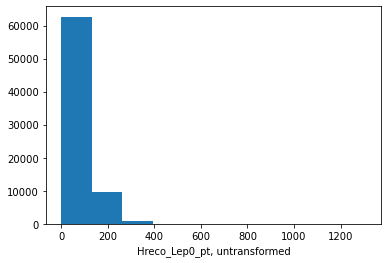

Plotting Hreco_Lep0_eta


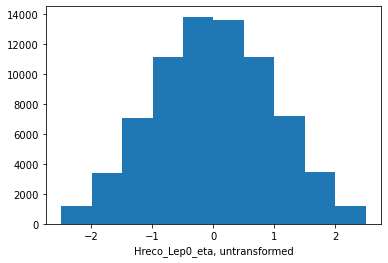

Plotting Hreco_Lep0_phi


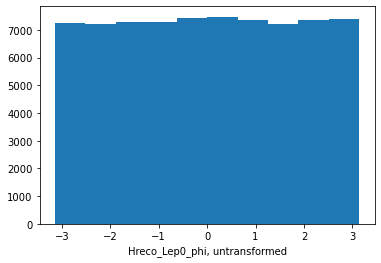

Plotting Hreco_Lep1_pt


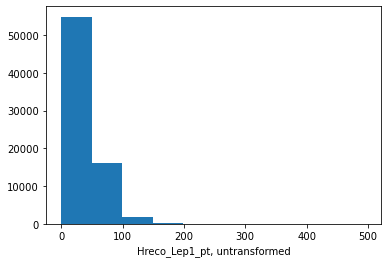

Plotting Hreco_Lep1_eta


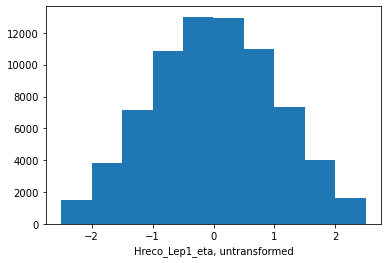

Plotting Hreco_Lep1_phi


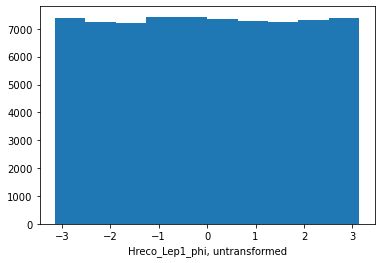

Plotting Hreco_Jet0_pt


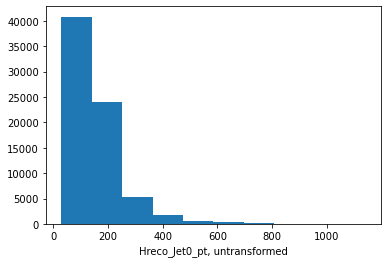

Plotting Hreco_Jet0_eta


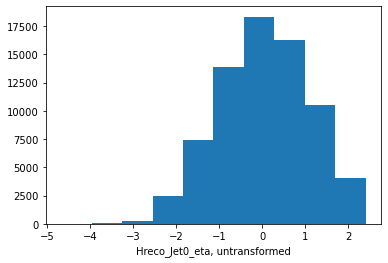

Plotting Hreco_Jet0_phi


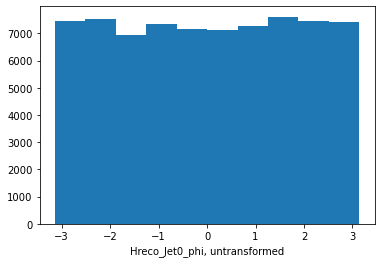

Plotting Hreco_Jet1_pt


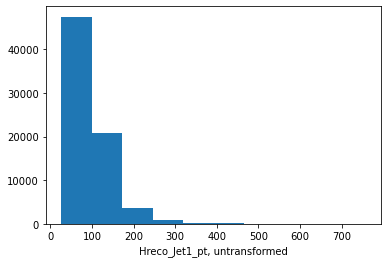

Plotting Hreco_Jet1_eta


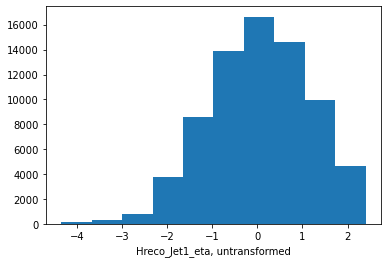

Plotting Hreco_Jet1_phi


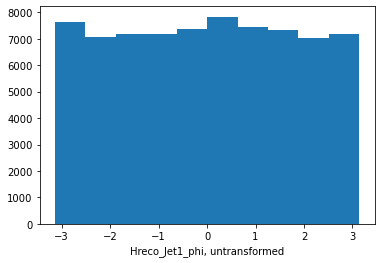

Plotting Hreco_Jet2_pt


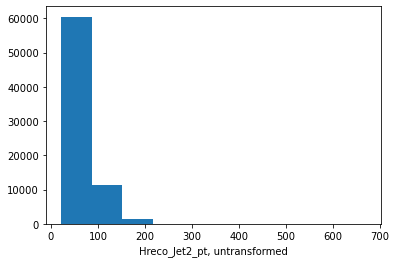

Plotting Hreco_Jet2_eta


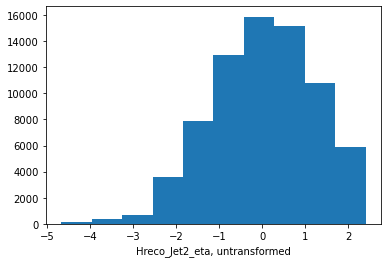

Plotting Hreco_Jet2_phi


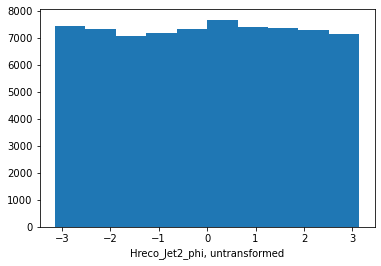

Plotting Hreco_Jet3_pt


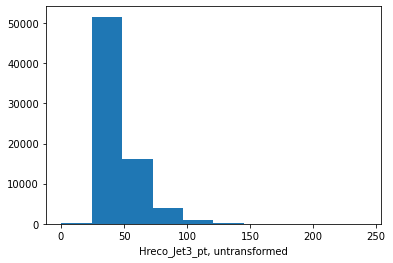

Plotting Hreco_Jet3_eta


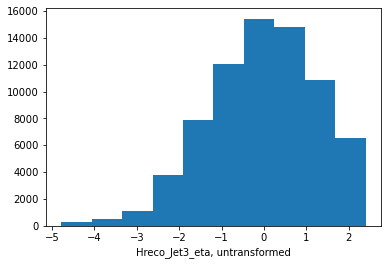

Plotting Hreco_Jet3_phi


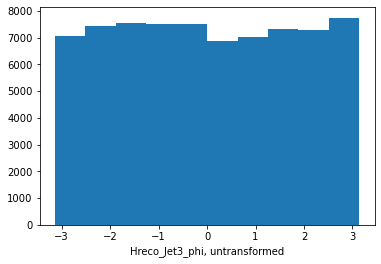

Plotting Hreco_Jet4_pt


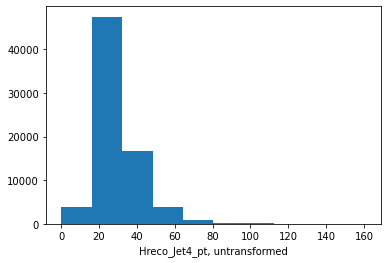

Plotting Hreco_Jet4_eta


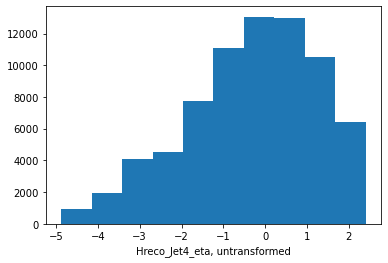

Plotting Hreco_Jet4_phi


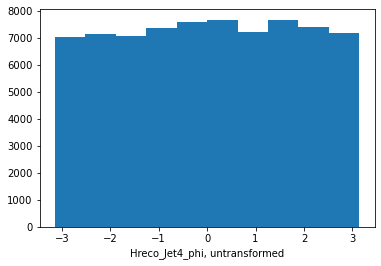

Plotting Hreco_Jet5_pt


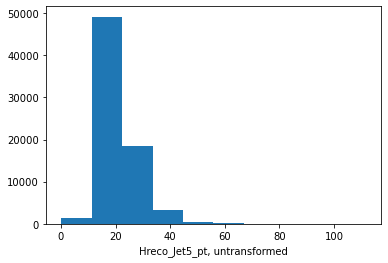

Plotting Hreco_Jet5_eta


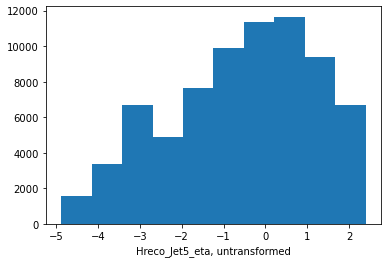

Plotting Hreco_Jet5_phi


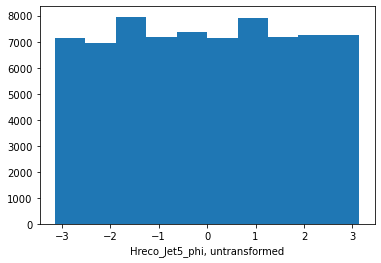

Plotting Hreco_HadTop_pt


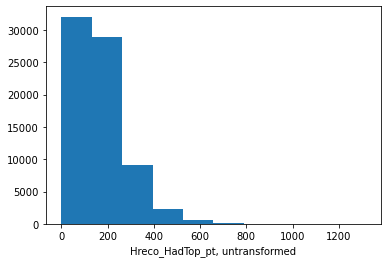

Plotting Hreco_HadTop_eta


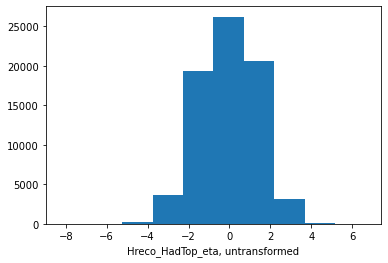

Plotting Hreco_HadTop_phi


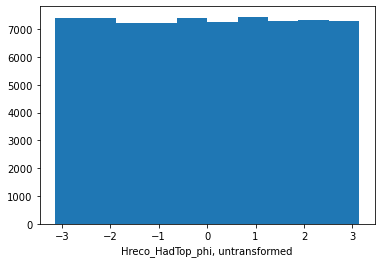

Plotting Hreco_TopScore


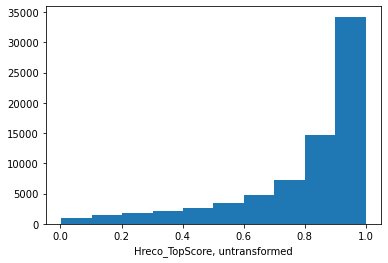

Plotting Hreco_met


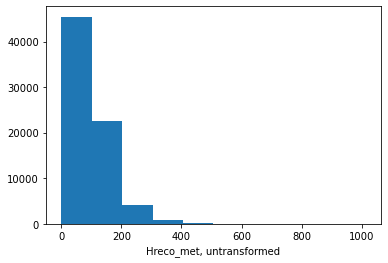

Plotting Hreco_DeltaRl0l1


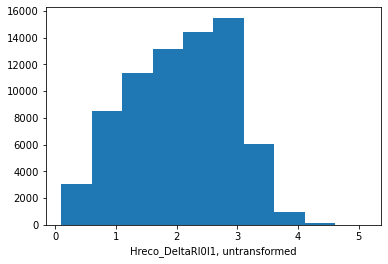

Plotting Hreco_met


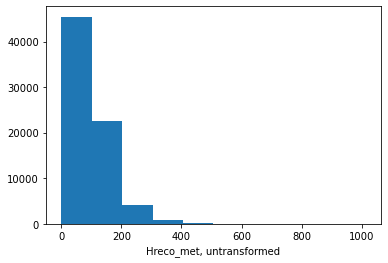

Plotting Hreco_HTXS_Higgs_pt


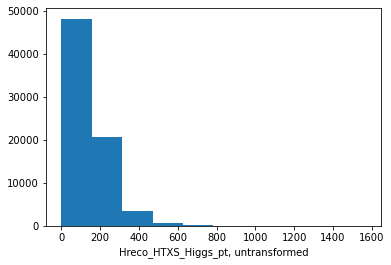

In [29]:

# Display the first few rows
viz=False
if viz:
    # pairplot is horrendously slow because it prints individually each point and keeps them in memory,
    # so plot only the first 100 entries
    myviz=data_tth.head(100) 
    sns.pairplot(myviz[thevars+target], diag_kind="kde")
    plt.show()
# Must do with subfig or something
for var in thevars+spect+target:
    print('Plotting', var)
    plt.hist(data_orig_tth[var])
    plt.xlabel('%s, untransformed'%var)
    plt.show()
    

In [30]:
# Split into datasets
# Use always the same random state (chosen by my cat) for reproducibility. Change it for random randomness
#traindataset, valdataset = train_test_split(data_tth, test_size=0.4, random_state=7)
x_train, x_test, y_train, y_test = train_test_split(data_tth[thevars], data_tth[target], random_state=7)

from sklearn.preprocessing import StandardScaler, MinMaxScaler
preprocess=False

if preprocess:
    print('Scaling training features')
    scaler = StandardScaler()
    scaler.fit(x_train.values)
    print('Transforming training and validation features')
    x_train_scaled = scaler.transform(x_train.values)
    x_test_scaled = scaler.transform(x_test.values)
    print('Plotting transformed features for the training set')
    if viz:
        # pairplot is horrendously slow because it prints individually each point and keeps them in memory,
        # so plot only the first 100 entries
        myviz=pd.DataFrame(x_train_scaled,columns=data_tth[thevars].columns)
        myviz_short=myviz.head(100)
        sns.pairplot(myviz_short[thevars[:10]], diag_kind="kde")
        plt.show()
        for var in thevars:
            plt.hist(myviz[var])
            plt.xlabel('%s, transformed'%var)
            plt.show()
    for var in target:
        print('Now plotting training target')
        print(y_train.shape)
        plt.hist(y_train[var])
        plt.xlabel('%s, transformed'%var)
        plt.show()
print('End. I use %s variables'%len(thevars))

End. I use 30 variables


In [31]:
# The model

def my_model(lr=5e-2):
    model = Sequential()
    model.add(Dense(3*len(thevars), input_dim=len(thevars), kernel_initializer='glorot_normal'))#TruncatedNormal'))
    #model.add(Dropout(0.2, input_shape=(len(thevars),))) # 20% dropout for input features
    for Nnodes in [3*len(thevars),2*len(thevars),len(thevars),int(len(thevars)/2)]:
        model.add(BatchNormalization())
        model.add(Dense(Nnodes, kernel_initializer='glorot_normal'))
        #model.add(PReLU())
        model.add(Activation('elu'))
        #model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(1, kernel_initializer='he_normal'))
    model.add(Activation('elu'))
    
    adam = optimizers.Adam(lr=lr,amsgrad=True) 
    #model.compile(loss='mean_absolute_percentage_error', optimizer=adam, metrics=['mse'])
    #model.compile(loss='mean_absolute_error', optimizer=adam)
    #model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mse'])
    model.compile(loss='mean_squared_logarithmic_error', optimizer=adam, metrics=['mse']) # logerror good if target range is vast
    #model.compile(loss='mean_absolute_error', optimizer=adam, metrics=['mse']) # logerror good if target range is vast
    return model


def my_training(lr,epochs=20):
    my_regression = KerasRegressor(
        build_fn=my_model, 
        epochs=epochs, 
        batch_size=256, 
        verbose=2,
        lr=lr
)
    cb_list = [PlotLossesKeras()]
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,min_delta=0.0001)
    earlyStopping=False
    if earlyStopping:
        cb_list.append(es)
    history = my_regression.fit(
        x_train if not preprocess else x_train_scaled, 
        y_train,
        validation_data=(
            x_test if not preprocess else x_test_scaled, 
            y_test
        ),
        callbacks=cb_list
    )
    return my_regression, history


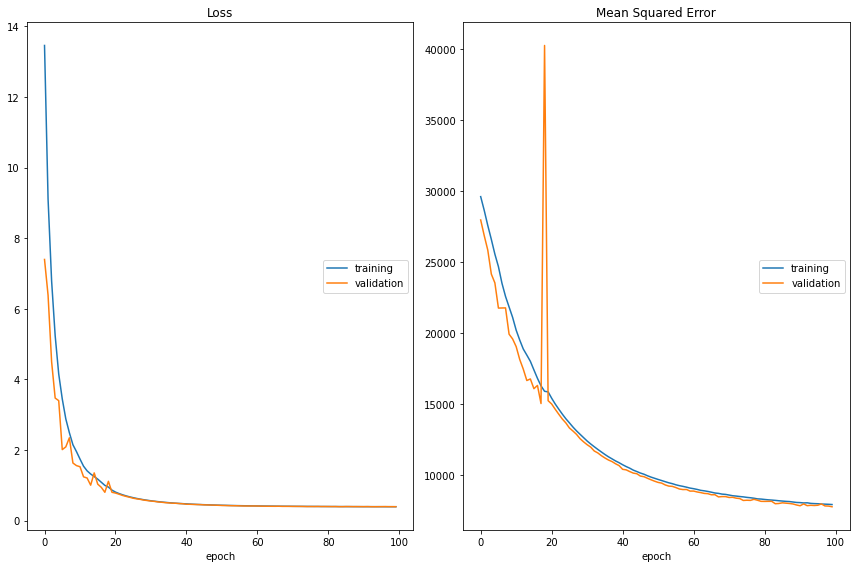

Loss
	training         	 (min:    0.395, max:   13.459, cur:    0.395)
	validation       	 (min:    0.396, max:    7.398, cur:    0.397)
Mean Squared Error
	training         	 (min: 7903.491, max: 29617.674, cur: 7903.491)
	validation       	 (min: 7748.200, max: 40278.078, cur: 7748.200)
215/215 - 1s - loss: 0.3951 - mse: 7903.4907 - val_loss: 0.3966 - val_mse: 7748.2002


In [32]:
model, hist= my_training(1e-3,epochs=100)
plt.show()


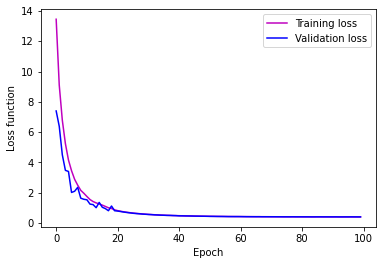

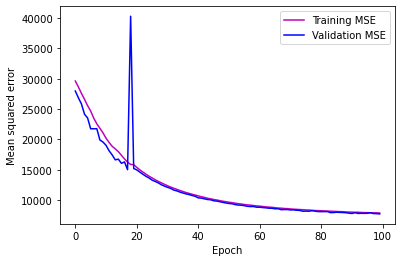

In [33]:
plt.plot(hist.history['loss'],color='m',label='Training loss')
plt.plot(hist.history['val_loss'],color='b',label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss function')
plt.legend(loc='upper right')
plt.show()
plt.plot(hist.history['mse'], color='m', label='Training MSE')
plt.plot(hist.history['val_mse'], color='b', label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean squared error')
plt.legend(loc='upper right')
plt.show()

import eli5
from sklearn.inspection import permutation_importance
doperm=False
if doperm:
    showvarimp=pd.DataFrame(x_train if not preprocess else x_train_scaled,columns=data_tth[thevars].columns)
    perm = PermutationImportance(model, random_state=1).fit(showvarimp,y_train)
    eli5.show_weights(perm, feature_names = showvarimp.columns.tolist())

72/72 - 0s
SHAPES (18323,) (1, 18323)


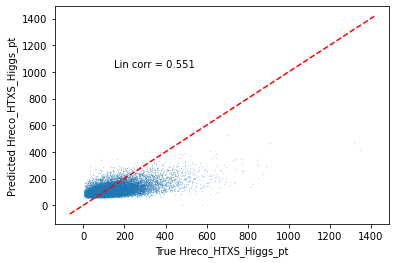

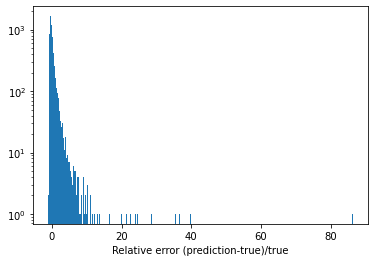

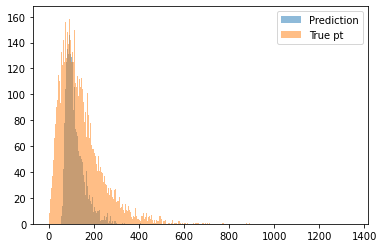

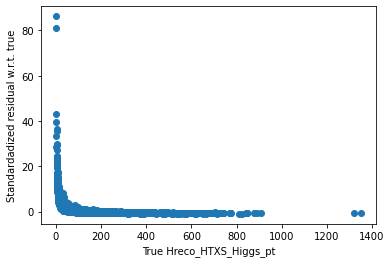

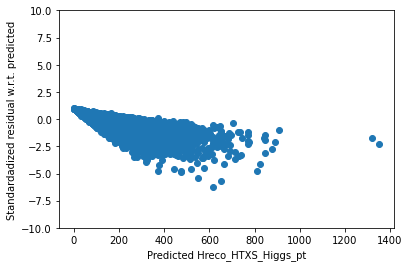

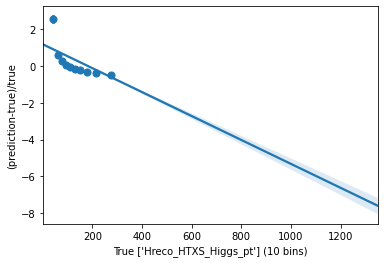

Shape of prediction: (18323,)
Shape of valdataset met: (18323, 1)
Shape of valdataset met values: (18323, 1)
Linear correlation: [[1.         0.55083677]
 [0.55083677 1.        ]]
Linear correlation (back to pt): None


In [34]:
# Now plot true pt vs predicted pt

import seaborn as sns

viz_x_test = x_test if not preprocess else x_test_scaled
viz_x_test=pd.DataFrame(viz_x_test,columns=data_tth[thevars].columns)
prediction = model.predict(viz_x_test.values)
lincorr = np.corrcoef(prediction, np.transpose(y_test))
print('SHAPES', prediction.shape, np.transpose(y_test).shape)
#vexp = np.vectorize(math.exp)
#blah = plt.scatter(vexp(y_test[target].values),vexp(prediction),s=0.01)
blah = plt.scatter(y_test[target].values,prediction,s=0.01)


plt.xlabel('True %s'%target[0])
plt.ylabel('Predicted %s'%target[0])
myxlim = plt.xlim()
myylim = plt.ylim()
lowcoord = min(myxlim[0],myylim[0]) if 'HTXS_Higgs_pt' not in target else 0
higcoord = max(myxlim[1],myylim[1])
_ = plt.plot([lowcoord,higcoord],[lowcoord,higcoord], c='red',ls='--')
plt.text((higcoord-lowcoord)*0.1,(higcoord-lowcoord)*0.7,'Lin corr = %.3f'%(lincorr[0,1]))
plt.show()


# Now plot the relative error between the predicted pt and true pt
diff = prediction-y_test[target].values.reshape(-1)
plt.hist(diff/y_test[target].values.reshape(-1),log=True,bins=1000)
plt.xlabel('Relative error (prediction-true)/true')
plt.show()
lincorrbacktopt=None


#plt.hist(vexp(prediction),alpha=0.5,log=False,bins=1000,label='Prediction')
#plt.hist(vexp(y_test[target].values),alpha=0.5,log=False,bins=1000,label='True pt')
#print('The SHAPES', prediction.shape, y_test[target].values.shape)
np.reshape(prediction,(prediction.shape[0],1))
plt.hist(prediction,alpha=0.5,log=False,bins=1000,label='Prediction')
plt.hist(y_test[target].values,alpha=0.5,log=False,bins=1000,label='True pt')
plt.legend(loc='upper right')
plt.show()
plt.scatter(y_test.values,diff/y_test[target].values.reshape(-1))
#plt.scatter(y_test[target].values,diff)
plt.xlabel('True %s'%target[0])
plt.ylabel('Standardadized residual w.r.t. true')
plt.show()
plt.scatter(y_test[target].values,diff/prediction.reshape(-1))
plt.ylim(-10,10)
#plt.scatter(prediction,diff)
plt.xlabel('Predicted %s'%target[0])
plt.ylabel('Standardadized residual w.r.t. predicted')
plt.show()
nxbins=10
ax = sns.regplot(y_test[target].values,diff/y_test[target].values.reshape(-1),x_bins=nxbins)
ax.set(xlabel='True %s (%s bins)'%(target,nxbins), ylabel='(prediction-true)/true')
plt.show()
if bkgs:
    ttv_prediction = model.predict(data_ttv[thevars].values)
    tt_prediction = model.predict(data_tt[thevars].values)
    ttv_manip = ttv_prediction
    tt_manip = tt_prediction
    plt.hist(prediction,alpha=0.5,density=True,log=True,bins=500,label='TTH Prediction')
    plt.hist(ttv_manip,alpha=0.5,density=True,log=True,bins=500,label='TTV Prediction')
    plt.hist(tt_manip,alpha=0.5,density=True,log=True,bins=500,label='TT Prediction')
    plt.legend(loc='upper right')
    plt.show()
print('Shape of prediction:', prediction.shape)
print('Shape of valdataset met:', viz_x_test[['Hreco_met']].shape)
print('Shape of valdataset met values:', viz_x_test[['Hreco_met']].values.shape)
print('Linear correlation:', lincorr)
print('Linear correlation (back to pt):', lincorrbacktopt)